In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.13498  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")

# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/root_analysis_env/output/skimmed/skim_run4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    'NPS.cal.clusE',
    'NPS.cal.clusT',
    'NPS.cal.clusX',
    'NPS.cal.clusY',
    'H.cal.eprtracknorm',
    'H.cal.etot',
    'H.cal.etotnorm',
    'H.cal.etottracknorm',
    'H.cal.etrack',
    'H.cal.etracknorm',
    'H.cer.npeSum',
    'H.dc.ntrack',
    'H.dc.x_fp',
    'H.dc.xp_fp',
    'H.dc.y_fp',
    'H.dc.yp_fp',
    'H.gtr.beta',
    'H.gtr.dp',
    'H.gtr.p',
    'H.gtr.ph',
    'H.gtr.px',
    'H.gtr.py',
    'H.gtr.pz',
    'H.gtr.th',
    'H.gtr.x',
    'H.gtr.y',
    'H.hod.betanotrack',
    'H.hod.fpHitsTime',
    'H.hod.goodscinhit',
    'H.hod.starttime',
    'H.react.z',
    'NPS.cal.nclust',
    'T.hms.hEDTM_tdcTimeRaw',
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'Ndata.NPS.cal.fly.block_clusterID',
 'NPS.cal.fly.block_clusterID',
 'Ndata.NPS.cal.fly.e',
 'NPS.cal.fly.e',
 'Ndata.NPS.cal.fly.goodAdcTdcDiffTime',
 'NPS.cal.fly.goodAdcTdcDiffTime',
 'Ndata.NPS.cal.vtpClusE',
 'NPS.cal.vtpClusE',
 'Ndata.NPS.cal.vtpClusSize',
 'NPS.cal.vtpClusSize',
 'Ndata.NPS.cal.vtpClusTime',
 'NPS.cal.vtpClusTime',
 'Ndata.NPS.cal.vtpClusX',
 'NPS.cal.vtpClusX',
 'Ndata.NPS.cal.vtpClusY',
 'NPS.cal.vtpClusY',
 'CTime.epCoinTime1_ROC1',
 'CTime.epCoinTime2_ROC1',
 'H.1MHz.scalerTime',
 'H.BCM2.scaler',
 'H.BCM2.scalerCharge',
 'H.BCM2.scalerChargeCut',
 'H.BCM2.scalerCurrent',
 'H.BCM2.scalerCut',
 'H.BCM4A.scaler',
 'H.BCM4A.scalerCharge',
 'H.BCM4A.scalerChargeCut',
 'H.BCM4A.scalerCurrent',
 'H.BCM4A.scalerCut',
 'H.EDTM.scaler',
 'H.S1X.scaler',
 'H.S1X.scalerCut',
 'H.S1X.scalerRate',
 'H.S

[info] Found 3222394 events in branches.
[info] Electron preselection passes: 2562129 / 3222394
[info] Merging done. Merged pairs: 484453  Events with merges: 409449
[info] Running Numba best-pair selection (mass)...
[info] Events with >=2 clusters: 1867180, with >2 clusters: 1286539

=== Top-2 cluster origin summary ===
Total events considered (electron preselection true): 2562129
Events with >=2 clusters: 1867180 (these needed for selection)

-- Mass best pairs --
Selected pairs: 421639
Both clusters from top-2: 127394 (30.2%)
At least one from top-2 : 223196 (52.9%)


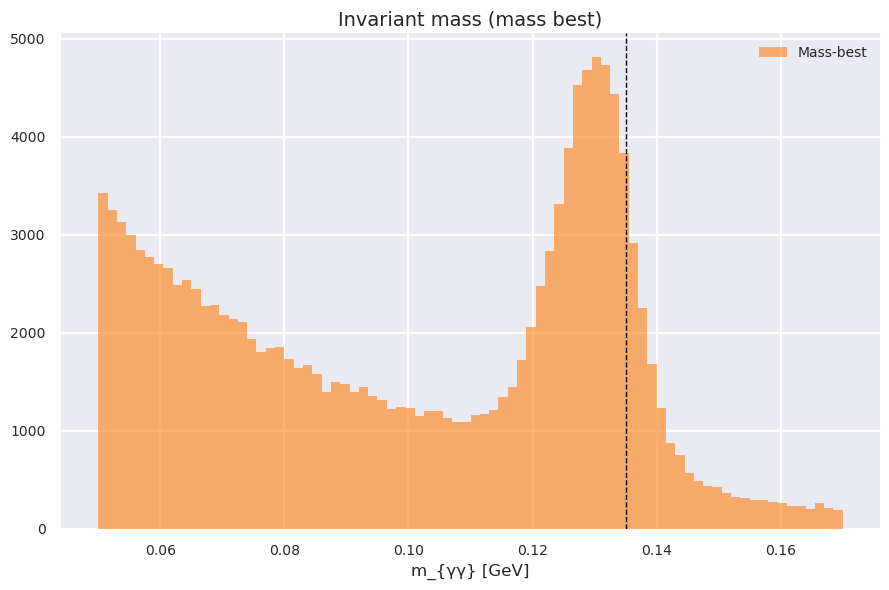

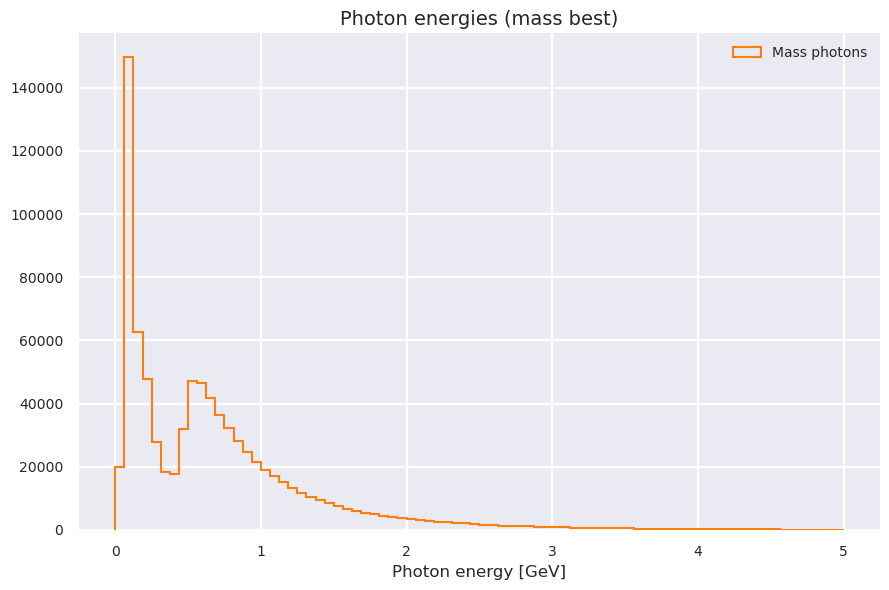

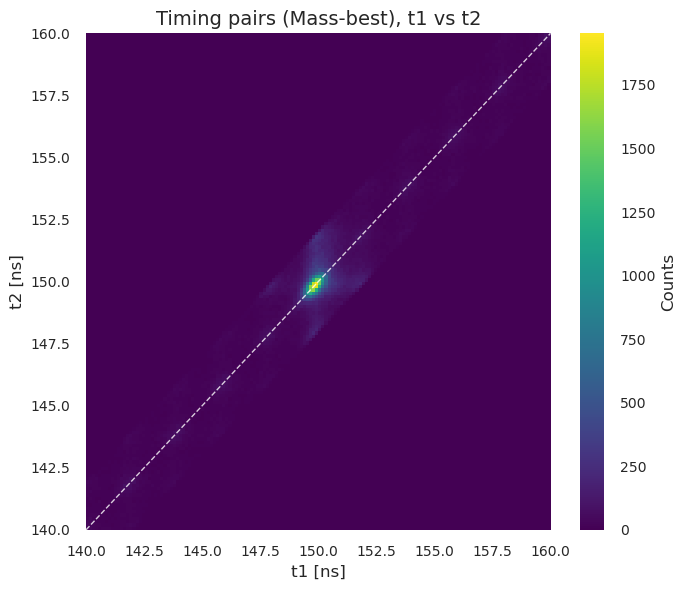

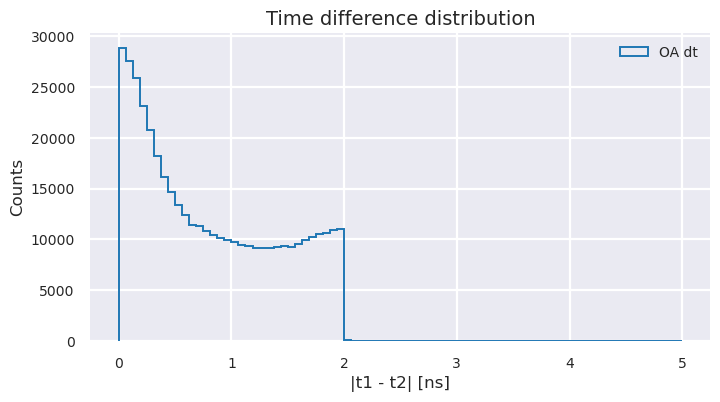


Done. Summary:

=== Top-2 cluster origin summary ===
Total events considered (electron preselection true): 2562129
Events with >=2 clusters: 1867180 (these needed for selection)

-- Mass best pairs --
Selected pairs: 421639
Both clusters from top-2: 127394 (30.2%)
At least one from top-2 : 223196 (52.9%)
Saved DataFrames: df_best_mass (len=421639)


In [15]:
# Complete updated pipeline: merging + Numba best-pair selection + top-2 check + nicer plots
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit, prange
from math import sqrt, acos, asin, pi
import matplotlib.pyplot as plt

# ----------------------------
# User-tweakable parameters
# ----------------------------
Z_NPS = 407.0            # detector z [cm]
TIME_WINDOW_NS = 2.0     # candidate pair must be within this dt
MERGE_SPACE2_THRESH = 50.0   # spatial squared threshold (cm^2) ~ 7.07 cm
MERGE_TIME_THRESH = 2.0      # merging time threshold (ns)
MIN_EVENTS_FOR_ANALYSIS = 1  # no. events to process (kept small by default)
SAVE_CSV = False              # set True to write CSVs

# ----------------------------
# Helper: safe branch fetch
# ----------------------------
def get_branch_safe(name, default=None):
    if name in branches.fields:
        return branches[name]
    else:
        print(f"[warn] branch '{name}' not found; using default={default}")
        return default

# ----------------------------
# Fetch needed branches (awkward arrays)
# ----------------------------
clusE_all = get_branch_safe("NPS.cal.clusE")
clusX_all = get_branch_safe("NPS.cal.clusX")
clusY_all = get_branch_safe("NPS.cal.clusY")
clusT_all = get_branch_safe("NPS.cal.clusT")

# optional electron preselection branches used earlier
edtmtdc_arr = get_branch_safe("T.hms.hEDTM_tdcTimeRaw", None)
hdelta_arr  = get_branch_safe("H.gtr.dp", None)
HgtrTh_arr  = get_branch_safe("H.gtr.th", None)
HgtrPh_arr  = get_branch_safe("H.gtr.ph", None)
hcer_arr    = get_branch_safe("H.cer.npeSum", None)

# sanity
if not isinstance(clusE_all, ak.Array):
    raise RuntimeError("NPS.cal.clusE not found or not an awkward array. Aborting.")

n_events = len(clusE_all)
print(f"[info] Found {n_events} events in branches.")

# ----------------------------
# Electron preselection mask (same as before)
# ----------------------------
def build_electron_mask():
    mask = np.ones(n_events, dtype=bool)
    if edtmtdc_arr is not None:
        ed = ak.to_numpy(edtmtdc_arr)
        # if ed is nested/array-of-length-1, try flattening gracefully
        try:
            mask &= (ed < 0.1)
        except Exception:
            mask &= (ak.to_numpy(ak.ravel(ed)) < 0.1)
    if hdelta_arr is not None:
        hd = ak.to_numpy(hdelta_arr)
        mask &= (hd > -15.0) & (hd < 15.0)
    if HgtrTh_arr is not None:
        th = ak.to_numpy(HgtrTh_arr)
        mask &= (th > -1.0) & (th < 1.0)
    if HgtrPh_arr is not None:
        ph = ak.to_numpy(HgtrPh_arr)
        mask &= (ph > -1.0) & (ph < 1.0)
    if hcer_arr is not None:
        cal = ak.to_numpy(hcer_arr)
        mask &= (cal > 0.001)
    return mask

ele_mask = build_electron_mask()
print(f"[info] Electron preselection passes: {ele_mask.sum()} / {n_events}")

# ----------------------------
# Convert awkward arrays -> Python lists of numpy arrays (one-time)
# This is memory-friendly enough: we convert per-event variable-length arrays to np arrays.
# ----------------------------
def ak_to_numpy_list(ak_arr):
    """Convert awkward array of variable-length lists -> python list of numpy arrays (float64)."""
    out = []
    for x in ak_arr:
        # ensure empty events become zero-length numpy arrays
        if x is None:
            out.append(np.zeros(0, dtype=np.float64))
        else:
            # convert element type safely
            arr = np.asarray(ak.to_list(x), dtype=np.float64)
            out.append(arr)
    return out

clusE_list = ak_to_numpy_list(clusE_all)
clusX_list = ak_to_numpy_list(clusX_all)
clusY_list = ak_to_numpy_list(clusY_all)
clusT_list = ak_to_numpy_list(clusT_all)

# ----------------------------
# Cluster merging (do in Python before Numba selection)
# - energy-weighted merge when two clusters are close in space & time
# - marks merged clusters by setting their energy to 0 (so they are ignored)
# ----------------------------
def merge_clusters_all(clusE_list, clusX_list, clusY_list, clusT_list,
                       space2_thresh=MERGE_SPACE2_THRESH, time_thresh=MERGE_TIME_THRESH):
    n_ev = len(clusE_list)
    merged_counts = 0
    merged_events = 0
    for ev in range(n_ev):
        E = clusE_list[ev]
        X = clusX_list[ev]
        Y = clusY_list[ev]
        T = clusT_list[ev]
        nclus = len(E)
        if nclus <= 1:
            continue
        event_merged = False
        # simple O(n^2) pairwise merging — fine for typical small cluster multiplicity
        for i in range(nclus - 1):
            if E[i] <= 0: continue
            for j in range(i+1, nclus):
                if E[j] <= 0: continue
                dx = X[i] - X[j]
                dy = Y[i] - Y[j]
                dt = abs(T[i] - T[j])
                space2 = dx*dx + dy*dy
                if space2 < space2_thresh and dt < time_thresh:
                    # merge j into i (energy-weighted)
                    E1 = E[i]; E2 = E[j]
                    Etot = E1 + E2
                    if Etot <= 0: 
                        E[i] = 0.0; E[j] = 0.0
                    else:
                        X[i] = (X[i]*E1 + X[j]*E2)/Etot
                        Y[i] = (Y[i]*E1 + Y[j]*E2)/Etot
                        T[i] = (T[i]*E1 + T[j]*E2)/Etot
                        E[i] = Etot
                        E[j] = 0.0  # mark as merged/invalid
                    merged_counts += 1
                    event_merged = True
        if event_merged:
            merged_events += 1
    print(f"[info] Merging done. Merged pairs: {merged_counts}  Events with merges: {merged_events}")
    return clusE_list, clusX_list, clusY_list, clusT_list

# perform merging in-place
clusE_list, clusX_list, clusY_list, clusT_list = merge_clusters_all(
    clusE_list, clusX_list, clusY_list, clusT_list,
    space2_thresh=MERGE_SPACE2_THRESH, time_thresh=MERGE_TIME_THRESH
)

# ----------------------------
# Helpers for physics (Numba-friendly versions)
# ----------------------------
@njit
def unit_vector_from_xy_numba(x, y, z):
    vx = x; vy = y; vz = z
    norm = sqrt(vx*vx + vy*vy + vz*vz)
    if norm == 0.0:
        return np.array([0.0, 0.0, 1.0])
    return np.array([vx/norm, vy/norm, vz/norm])

@njit
def ideal_opening_angle_numba(E1, E2, m_pi_local=0.135):
    denom = 4.0 * E1 * E2
    if denom <= 0.0:
        return pi
    arg = (m_pi_local**2) / denom
    if arg <= 0.0:
        return 0.0
    if arg >= 1.0:
        return pi
    return 2.0 * asin(sqrt(arg))

@njit
def invariant_mass_numba(E1, x1, y1, E2, x2, y2, z, m_pi_local=0.135):
    u1 = unit_vector_from_xy_numba(x1, y1, z)
    u2 = unit_vector_from_xy_numba(x2, y2, z)
    p1x, p1y, p1z = E1 * u1[0], E1 * u1[1], E1 * u1[2]
    p2x, p2y, p2z = E2 * u2[0], E2 * u2[1], E2 * u2[2]
    Etot = E1 + E2
    px = p1x + p2x; py = p1y + p2y; pz = p1z + p2z
    mass2 = Etot*Etot - (px*px + py*py + pz*pz)
    if mass2 <= 0.0:
        return 0.0
    return sqrt(mass2)

# ----------------------------
# Numba-accelerated best-pair selector
# method_flag: 0 => opening angle, 1 => mass
# ----------------------------
@njit(parallel=True)
def select_best_pairs_numba(clusE_list, clusX_list, clusY_list, clusT_list,
                            event_mask, method_flag, time_window_ns, Z_NPS_local):
    n_ev = len(clusE_list)
    best_pairs = np.full((n_ev, 2), -1, dtype=np.int64)
    sel_energy_sum = np.full(n_ev, np.nan)
    sel_m_inv = np.full(n_ev, np.nan)
    sel_opening = np.full(n_ev, np.nan)
    sel_dt = np.full(n_ev, np.nan)

    for ev in prange(n_ev):
        if not event_mask[ev]:
            continue
        e_list = clusE_list[ev]
        x_list = clusX_list[ev]
        y_list = clusY_list[ev]
        t_list = clusT_list[ev]
        nclus = len(e_list)
        if nclus < 2:
            continue

        best_score = 1e9
        i_best = -1
        j_best = -1

        for i in range(nclus - 1):
            if e_list[i] <= 0.0:  # skip merged/inactive
                continue
            for j in range(i+1, nclus):
                if e_list[j] <= 0.0:
                    continue
                dt = abs(t_list[i] - t_list[j])
                if dt > time_window_ns:
                    continue
                E1 = e_list[i]; E2 = e_list[j]
                x1 = x_list[i]; y1 = y_list[i]
                x2 = x_list[j]; y2 = y_list[j]

                # compute angles / mass
                u1 = unit_vector_from_xy_numba(x1, y1, Z_NPS_local)
                u2 = unit_vector_from_xy_numba(x2, y2, Z_NPS_local)
                dot = u1[0]*u2[0] + u1[1]*u2[1] + u1[2]*u2[2]
                if dot > 1.0: dot = 1.0
                if dot < -1.0: dot = -1.0
                theta_data = acos(dot)
                theta_ideal = ideal_opening_angle_numba(E1, E2)
                m_inv = invariant_mass_numba(E1, x1, y1, E2, x2, y2, Z_NPS_local)

                if method_flag == 0:
                    score = abs(theta_data - theta_ideal)
                else:
                    score = abs(m_inv - 0.135)  # m_pi

                if score < best_score:
                    best_score = score
                    i_best = i
                    j_best = j
                    sel_energy_sum[ev] = E1 + E2
                    sel_m_inv[ev] = m_inv
                    sel_opening[ev] = theta_data
                    sel_dt[ev] = dt

        best_pairs[ev, 0] = i_best
        best_pairs[ev, 1] = j_best

    return best_pairs, sel_energy_sum, sel_m_inv, sel_opening, sel_dt

# ----------------------------
# Prepare event mask as numpy bool array for numba
# ----------------------------
event_mask = np.asarray(ele_mask, dtype=np.bool_)

# ----------------------------
# Run selections (OA and Mass)
# ----------------------------
# print("[info] Running Numba best-pair selection (opening-angle)...")
# best_oa, E_oa, M_oa, Th_oa, Dt_oa = select_best_pairs_numba(
#     clusE_list, clusX_list, clusY_list, clusT_list, event_mask, 0, TIME_WINDOW_NS, Z_NPS
# )
print("[info] Running Numba best-pair selection (mass)...")
best_mass, E_mass, M_mass, Th_mass, Dt_mass = select_best_pairs_numba(
    clusE_list, clusX_list, clusY_list, clusT_list, event_mask, 1, TIME_WINDOW_NS, Z_NPS
)

# ----------------------------
# Compute top-2 indices per event (python-level)
# ----------------------------
top2_indices = [set() for _ in range(n_events)]
n_with_ge_2 = 0
n_with_gt2 = 0
for ev in range(n_events):
    E = clusE_list[ev]
    if len(E) >= 2:
        n_with_ge_2 += 1
    if len(E) > 2:
        n_with_gt2 += 1
    if len(E) == 0:
        continue
    # sort indices by energy descending, ignore clusters with energy<=0 (merged)
    idxs = [i for i in range(len(E)) if E[i] > 0.0]
    if len(idxs) == 0:
        continue
    sorted_idxs = sorted(idxs, key=lambda k: E[k], reverse=True)
    # add top 2 (if available)
    for k in range(min(2, len(sorted_idxs))):
        top2_indices[ev].add(sorted_idxs[k])

print(f"[info] Events with >=2 clusters: {n_with_ge_2}, with >2 clusters: {n_with_gt2}")

# ----------------------------
# Build DataFrames and compute 'both_top2' & 'one_top2' booleans for selected pairs
# also include cluster times in the dataframe
# ----------------------------
# rows_oa = []
rows_mass = []

# count_both_top2_oa = 0
# count_one_top2_oa = 0
# count_total_selected_oa = 0

count_both_top2_mass = 0
count_one_top2_mass = 0
count_total_selected_mass = 0

for ev in range(n_events):
    # Opening-angle best pair
    # i_oa = int(best_oa[ev,0]); j_oa = int(best_oa[ev,1])
    # if i_oa >= 0:
    #     count_total_selected_oa += 1
    #     E1 = float(clusE_list[ev][i_oa]); E2 = float(clusE_list[ev][j_oa])
    #     t1 = float(clusT_list[ev][i_oa]); t2 = float(clusT_list[ev][j_oa])
    #     topset = top2_indices[ev]
    #     both_top2 = (i_oa in topset) and (j_oa in topset)
    #     one_top2 = (i_oa in topset) or (j_oa in topset)
    #     if both_top2: count_both_top2_oa += 1
    #     elif one_top2: count_one_top2_oa += 1
    #     rows_oa.append({
    #         "event": ev, "i": i_oa, "j": j_oa,
    #         "E1": E1, "E2": E2, "Etot": E1+E2,
    #         "t1": t1, "t2": t2, "dt": abs(t1-t2),
    #         "m_inv": float(M_oa[ev]), "theta": float(Th_oa[ev]),
    #         "both_top2": both_top2, "one_top2": one_top2, "nclus": len(clusE_list[ev])
    #     })

    # Mass best pair
    i_m = int(best_mass[ev,0]); j_m = int(best_mass[ev,1])
    if i_m >= 0:
        count_total_selected_mass += 1
        E1 = float(clusE_list[ev][i_m]); E2 = float(clusE_list[ev][j_m])
        t1 = float(clusT_list[ev][i_m]); t2 = float(clusT_list[ev][j_m])
        topset = top2_indices[ev]
        both_top2 = (i_m in topset) and (j_m in topset)
        one_top2 = (i_m in topset) or (j_m in topset)
        if both_top2: count_both_top2_mass += 1
        elif one_top2: count_one_top2_mass += 1
        rows_mass.append({
            "event": ev, "i": i_m, "j": j_m,
            "E1": E1, "E2": E2, "Etot": E1+E2,
            "t1": t1, "t2": t2, "dt": abs(t1-t2),
            "m_inv": float(M_mass[ev]), "theta": float(Th_mass[ev]),
            "both_top2": both_top2, "one_top2": one_top2, "nclus": len(clusE_list[ev])
        })

# DataFrames
# df_best_oa = pd.DataFrame(rows_oa)
df_best_mass = pd.DataFrame(rows_mass)

# ----------------------------
# Print the top-2 summary info
# ----------------------------
def print_top2_summary():
    print("\n=== Top-2 cluster origin summary ===")
    print(f"Total events considered (electron preselection true): {event_mask.sum()}")
    print(f"Events with >=2 clusters: {n_with_ge_2} (these needed for selection)")
    # print("\n-- Opening-angle best pairs --")
    # print(f"Selected pairs: {count_total_selected_oa}")
    # if count_total_selected_oa > 0:
    #     print(f"Both clusters from top-2: {count_both_top2_oa} ({100.0*count_both_top2_oa/count_total_selected_oa:.1f}%)")
    #     print(f"At least one from top-2 : {count_one_top2_oa} ({100.0*count_one_top2_oa/count_total_selected_oa:.1f}%)")
    print("\n-- Mass best pairs --")
    print(f"Selected pairs: {count_total_selected_mass}")
    if count_total_selected_mass > 0:
        print(f"Both clusters from top-2: {count_both_top2_mass} ({100.0*count_both_top2_mass/count_total_selected_mass:.1f}%)")
        print(f"At least one from top-2 : {count_one_top2_mass} ({100.0*count_one_top2_mass/count_total_selected_mass:.1f}%)")

print_top2_summary()

# ----------------------------
# Optional: save CSVs
# ----------------------------
if SAVE_CSV:
    df_best_oa.to_csv("best_pairs_opening_angle_with_times.csv", index=False)
    df_best_mass.to_csv("best_pairs_mass_with_times.csv", index=False)
    print("[info] CSVs saved.")

# ----------------------------
# Plotting utilities (nicer visuals)
# ----------------------------
import matplotlib as mpl
mpl.rcParams.update({
    "figure.figsize": (9,6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

# def plot_invariant_masses(df_oa, df_mass, save=False):
#     plt.figure(figsize=(10,4))
#     plt.subplot(1,2,1)
#     plt.hist(df_oa['m_inv'].dropna(), bins=80, range=(0.0,0.3), histtype='stepfilled', alpha=0.6, label='OA-best')
#     plt.axvline(0.135, color='k', ls='--', lw=1)
#     plt.xlabel("m_{γγ} [GeV]"); plt.ylabel("Counts"); plt.title("Invariant mass (OA best)"); plt.legend()
#     plt.subplot(1,2,2)
#     plt.hist(df_mass['m_inv'].dropna(), bins=80, range=(0.0,0.3), histtype='stepfilled', alpha=0.6, color='C1', label='Mass-best')
#     plt.axvline(0.135, color='k', ls='--', lw=1)
#     plt.xlabel("m_{γγ} [GeV]"); plt.title("Invariant mass (mass best)"); plt.legend()
#     plt.tight_layout()
#     if save: plt.savefig("pi0_invariant_masses.png", dpi=200)
#     plt.show()

def plot_invariant_masses(df_mass, save=False):
    # plt.figure(figsize=(10,4))
    # plt.subplot(1,2,1)
    # plt.hist(df_oa['m_inv'].dropna(), bins=80, range=(0.0,0.3), histtype='stepfilled', alpha=0.6, label='OA-best')
    # plt.axvline(0.135, color='k', ls='--', lw=1)
    # plt.xlabel("m_{γγ} [GeV]"); plt.ylabel("Counts"); plt.title("Invariant mass (OA best)"); plt.legend()
    # plt.subplot(1,2,2)
    plt.hist(df_mass['m_inv'].dropna(), bins=80, range=(0.05,0.17), histtype='stepfilled', alpha=0.6, color='C1', label='Mass-best')
    plt.axvline(0.135, color='k', ls='--', lw=1)
    plt.xlabel("m_{γγ} [GeV]"); plt.title("Invariant mass (mass best)"); plt.legend()
    plt.tight_layout()
    if save: plt.savefig("pi0_invariant_masses.png", dpi=200)
    plt.show()

# def plot_photon_energies(df_oa, df_mass, save=False):
#     plt.figure(figsize=(10,4))
#     plt.subplot(1,2,1)
#     data = np.concatenate([df_oa['E1'].values, df_oa['E2'].values]) if len(df_oa)>0 else np.array([])
#     plt.hist(data, bins=80, range=(0,10), histtype='step', linewidth=1.5, label='OA photons')
#     plt.xlabel("Photon energy [GeV]"); plt.ylabel("Counts"); plt.title("Photon energies (OA best)"); plt.legend()
#     plt.subplot(1,2,2)
#     data2 = np.concatenate([df_mass['E1'].values, df_mass['E2'].values]) if len(df_mass)>0 else np.array([])
#     plt.hist(data2, bins=80, range=(0,10), histtype='step', linewidth=1.5, color='C1', label='Mass photons')
#     plt.xlabel("Photon energy [GeV]"); plt.title("Photon energies (mass best)"); plt.legend()
#     plt.tight_layout()
#     if save: plt.savefig("pi0_photon_energies.png", dpi=200)
#     plt.show()

def plot_photon_energies(df_mass, save=False):
    # plt.figure(figsize=(10,4))
    # plt.subplot(1,2,1)
    # data = np.concatenate([df_oa['E1'].values, df_oa['E2'].values]) if len(df_oa)>0 else np.array([])
    # plt.hist(data, bins=80, range=(0,10), histtype='step', linewidth=1.5, label='OA photons')
    # plt.xlabel("Photon energy [GeV]"); plt.ylabel("Counts"); plt.title("Photon energies (OA best)"); plt.legend()
    # plt.subplot(1,2,2)
    data2 = np.concatenate([df_mass['E1'].values, df_mass['E2'].values]) if len(df_mass)>0 else np.array([])
    plt.hist(data2, bins=80, range=(0,5), histtype='step', linewidth=1.5, color='C1', label='Mass photons')
    plt.xlabel("Photon energy [GeV]"); plt.title("Photon energies (mass best)"); plt.legend()
    plt.tight_layout()
    if save: plt.savefig("pi0_photon_energies.png", dpi=200)
    plt.show()

def plot_timing_heatmap(df, title="Timing pairs (t1 vs t2)", bins=150, tmin=140.0, tmax=160.0, save=False):
    if len(df) == 0:
        print("[warn] no data to plot for timing heatmap")
        return
    t1 = df['t1'].values
    t2 = df['t2'].values
    # 2D histogram via numpy (memory-efficient)
    H, xedges, yedges = np.histogram2d(t1, t2, bins=bins, range=[[tmin, tmax],[tmin,tmax]])
    H = H.T  # transpose for proper orientation with pcolormesh
    fig, ax = plt.subplots(figsize=(7,6))
    pcm = ax.pcolormesh(xedges, yedges, H, cmap='viridis', shading='auto')
    ax.set_xlabel("t1 [ns]"); ax.set_ylabel("t2 [ns]"); ax.set_title(title)
    ax.plot([tmin,tmax],[tmin,tmax], color='white', linestyle='--', linewidth=1.0, alpha=0.8)
    cb = fig.colorbar(pcm, ax=ax, label='Counts')
    # ensure scalar formatter on colorbar (avoid ScalarFormatter error)
    from matplotlib.ticker import ScalarFormatter
    cb.ax.yaxis.set_major_formatter(ScalarFormatter())
    plt.tight_layout()
    if save: plt.savefig(f"{title.replace(' ','_')}.png", dpi=200)
    plt.show()

def plot_timing_dt_hist(df1, df2=None, save=False):
    plt.figure(figsize=(8,4))
    if len(df1)>0:
        plt.hist(df1['dt'].values, bins=80, range=(0,5), histtype='step', linewidth=1.4, label='OA dt')
    if df2 is not None and len(df2)>0:
        plt.hist(df2['dt'].values, bins=80, range=(0,5), histtype='step', linewidth=1.4, label='Mass dt', color='C1')
    plt.xlabel("|t1 - t2| [ns]"); plt.ylabel("Counts"); plt.title("Time difference distribution")
    plt.legend()
    if save: plt.savefig("pi0_dt_hist.png", dpi=200)
    plt.show()

# ----------------------------
# Run plotting
# ----------------------------
# plot_invariant_masses(df_best_oa, df_best_mass)
# plot_photon_energies(df_best_oa, df_best_mass)
plot_invariant_masses(df_best_mass)
plot_photon_energies(df_best_mass)
# plot_timing_heatmap(df_best_oa, title="Timing pairs (OA-best), t1 vs t2")
plot_timing_heatmap(df_best_mass, title="Timing pairs (Mass-best), t1 vs t2")
plot_timing_dt_hist(df_best_mass)

# ----------------------------
# Final printed summary
# ----------------------------
print("\nDone. Summary:")
print_top2_summary()
# print(f"Saved DataFrames: df_best_oa (len={len(df_best_oa)}), df_best_mass (len={len(df_best_mass)})")
print(f"Saved DataFrames: df_best_mass (len={len(df_best_mass)})")
if SAVE_CSV:
    print("CSV files written.")


In [32]:
df_best_mass[(df_best_mass['nclus'] == 2) & (df_best_mass['both_top2'] == True)]


,event,i,j,E1,E2,Etot,t1,t2,dt,m_inv,theta,both_top2,one_top2,nclus
3,13,0,1,0.606307,0.586111,1.192417,150.695207,150.629666,0.065540,0.030412,0.051021,True,True,2
24,129,0,1,0.374360,0.140355,0.514716,160.164324,160.662560,0.498237,0.023333,0.101836,True,True,2
27,142,0,1,0.963888,1.668724,2.632612,151.512261,149.585512,1.926749,0.130315,0.102797,True,True,2
30,166,0,1,0.791505,0.569436,1.360942,149.919452,151.299822,1.380370,0.045242,0.067402,True,True,2
57,368,0,1,2.894360,0.684223,3.578583,150.109165,148.235613,1.873551,0.047850,0.034004,True,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421617,3222260,0,1,0.466252,0.066021,0.532273,144.037485,142.976817,1.060668,0.003651,0.020808,True,True,2
421624,3222331,0,1,0.280684,0.122445,0.403129,120.799647,121.058585,0.258938,0.004179,0.022542,True,True,2
421626,3222334,0,1,0.840708,0.173560,1.014268,137.673107,138.566191,0.893084,0.007118,0.018635,True,True,2
421634,3222371,0,1,0.519980,0.725063,1.245043,150.081561,149.592231,0.489330,0.010763,0.017530,True,True,2


In [19]:
# ======================================================
# Multiplicity and coincidence-based background analysis
# Assumes t1, t2, dt columns in df_best_oa / df_best_mass
# and cluster lists (clusE_list, clusT_list, event_mask)
# ======================================================
import numpy as np
from collections import Counter

# --- Parameters ---
TIME_WINDOW_NS = 2.0        # photon-photon coincidence window
COIN_CENTER_NS = 150.0      # nominal coincidence time with electron
ELE_COIN_WINDOW = 2.0       # window around 150ns = in-coincidence with electron
SIDEBAND_RANGES = [(3.0,5.0), (5.0,7.0)]   # ns, for accidental background

# --- Multiplicity summary (number of clusters per event)
multiplicities = []
for ev in range(len(clusE_list)):
    E = np.asarray(clusE_list[ev])
    ncl = np.count_nonzero(E > 0)
    multiplicities.append(int(ncl))

mult_counts = Counter(multiplicities)
total_events = len(multiplicities)

print("\n=== Cluster multiplicity summary (post-merge) ===")
for m in sorted(mult_counts.keys()):
    cnt = mult_counts[m]
    print(f" multiplicity = {m:2d} : {cnt:6d} events  ({100.0*cnt/total_events:5.2f}%)")
n_ge2 = sum(c for k,c in mult_counts.items() if k>=2)
print(f"Events with ≥2 clusters: {n_ge2} ({100.0*n_ge2/total_events:5.2f}%)")

# --- Helper: classify coincidence categories (based only on cluster times)
def classify_coincidence(t1, t2, coin_center=COIN_CENTER_NS, ele_win=ELE_COIN_WINDOW, dt_win=TIME_WINDOW_NS):
    """
    Returns:
      'both_in' : both clusters within ±ele_win of 150 ns
      'one_in'  : one cluster near 150 ns
      'none_in' : neither near 150 ns
    Additionally uses |t1 - t2| <= dt_win to tag photon-photon coincidence
    """
    c1 = abs(t1 - coin_center) <= ele_win
    c2 = abs(t2 - coin_center) <= ele_win
    if c1 and c2:
        return 'both_in'
    if c1 or c2:
        return 'one_in'
    return 'none_in'

# --- Function to compute timing-based stats for each selection (OA or mass)
def analyze_timing(df, label=""):
    dt = np.abs(df['dt'].values)
    t1 = df['t1'].values
    t2 = df['t2'].values
    n_total = len(dt)
    central_mask = dt <= TIME_WINDOW_NS
    central_count = int(np.count_nonzero(central_mask))

    # Sideband counts
    sideband_counts = []
    for (lo, hi) in SIDEBAND_RANGES:
        sideband_counts.append(int(np.count_nonzero((dt>=lo) & (dt<hi))))

    # Coincidence categories in central region
    cat_counts = {'both_in':0, 'one_in':0, 'none_in':0}
    for i,flag in enumerate(central_mask):
        if not flag: continue
        cat = classify_coincidence(t1[i], t2[i])
        cat_counts[cat] += 1

    # Sideband category counts (for accidental structure)
    sidecat_counts = {'both_in':0, 'one_in':0, 'none_in':0}
    for i,d in enumerate(dt):
        for (lo,hi) in SIDEBAND_RANGES:
            if d>=lo and d<hi:
                cat = classify_coincidence(t1[i], t2[i])
                sidecat_counts[cat] += 1
                break

    # Background estimate: average scaled sideband → central width
    widths = [hi-lo for (lo,hi) in SIDEBAND_RANGES]
    scaled = [c * (TIME_WINDOW_NS/w) for c,w in zip(sideband_counts,widths)]
    bkg_est = float(np.mean(scaled)) if scaled else 0.0
    signal_est = central_count - bkg_est

    print(f"\n=== {label} pairs ===")
    print(f"Total pairs: {n_total}")
    print(f"Central coincidence count (|Δt| ≤ {TIME_WINDOW_NS:.1f} ns): {central_count}")
    print(f"Sideband counts (|Δt| in {SIDEBAND_RANGES}): {sideband_counts}")
    print(f"Estimated accidental background ≈ {bkg_est:.1f}, signal ≈ {signal_est:.1f}")
    print("Central region coincidence categories (relative to 150 ns):")
    for k,v in cat_counts.items():
        print(f"  {k:7s} : {v:6d}")
    print("Sideband coincidence categories:")
    for k,v in sidecat_counts.items():
        print(f"  {k:7s} : {v:6d}")

    return {
        'central_count': central_count,
        'sideband_counts': sideband_counts,
        'bkg_est': bkg_est,
        'signal_est': signal_est,
        'cat_counts': cat_counts,
        'sidecat_counts': sidecat_counts,
        'n_total': n_total
    }

# --- Run for OA-best and Mass-best
# stats_oa = analyze_timing(df_best_oa, label="Opening-angle (OA) best")
stats_mass = analyze_timing(df_best_mass, label="Mass-best")

print("\n=== Notes for background subtraction ===")
print(" - The central |t1−t2| ≤ 2 ns region represents true photon-photon coincidences.")
print(" - The 150 ns window (±2 ns) defines coincidence with the electron time.")
print(" - Sidebands (3–5 ns, 5–7 ns) represent accidental coincidences.")
print(" - You can use sidebands to estimate and subtract background counts under the coincidence peak.")
print(" - The printed category breakdown helps check how many pairs have both, one, or none of their clusters near 150 ns.")
print(" - Next step: 2D histogram (t1 vs t2) to visualize coincidence band vs background bands.")



=== Cluster multiplicity summary (post-merge) ===
 multiplicity =  0 : 730382 events  (22.67%)
 multiplicity =  1 : 666718 events  (20.69%)
 multiplicity =  2 : 616661 events  (19.14%)
 multiplicity =  3 : 470452 events  (14.60%)
 multiplicity =  4 : 318845 events  ( 9.89%)
 multiplicity =  5 : 194623 events  ( 6.04%)
 multiplicity =  6 : 110464 events  ( 3.43%)
 multiplicity =  7 :  59038 events  ( 1.83%)
 multiplicity =  8 :  29642 events  ( 0.92%)
 multiplicity =  9 :  14058 events  ( 0.44%)
 multiplicity = 10 :   6555 events  ( 0.20%)
 multiplicity = 11 :   2883 events  ( 0.09%)
 multiplicity = 12 :   1212 events  ( 0.04%)
 multiplicity = 13 :    526 events  ( 0.02%)
 multiplicity = 14 :    203 events  ( 0.01%)
 multiplicity = 15 :     86 events  ( 0.00%)
 multiplicity = 16 :     30 events  ( 0.00%)
 multiplicity = 17 :      8 events  ( 0.00%)
 multiplicity = 18 :      7 events  ( 0.00%)
 multiplicity = 19 :      1 events  ( 0.00%)
Events with ≥2 clusters: 1825294 (56.64%)

=== Ma

=== Multiplicity summary (all events) ===
  nclus =  0 :  730382 events  (22.67%)
  nclus =  1 :  624832 events  (19.39%)
  nclus =  2 :  580641 events  (18.02%)
  nclus =  3 :  457095 events  (14.18%)
  nclus =  4 :  325311 events  (10.10%)
  nclus =  5 :  212026 events  ( 6.58%)
  nclus =  6 :  130115 events  ( 4.04%)
  nclus =  7 :   75251 events  ( 2.34%)
  nclus =  8 :   42140 events  ( 1.31%)
  nclus =  9 :   22260 events  ( 0.69%)
  nclus = 10 :   11445 events  ( 0.36%)
  nclus = 11 :    5753 events  ( 0.18%)
  nclus = 12 :    2725 events  ( 0.08%)
  nclus = 13 :    1277 events  ( 0.04%)
  nclus = 14 :     616 events  ( 0.02%)
  nclus = 15 :     296 events  ( 0.01%)
  nclus = 16 :     137 events  ( 0.00%)
  nclus = 17 :      57 events  ( 0.00%)
  nclus = 18 :      23 events  ( 0.00%)
  nclus = 19 :       7 events  ( 0.00%)
  nclus = 20 :       1 events  ( 0.00%)
  nclus = 21 :       4 events  ( 0.00%)
Total events: 3222394

[info] Events with exactly 2 clusters & passing electro

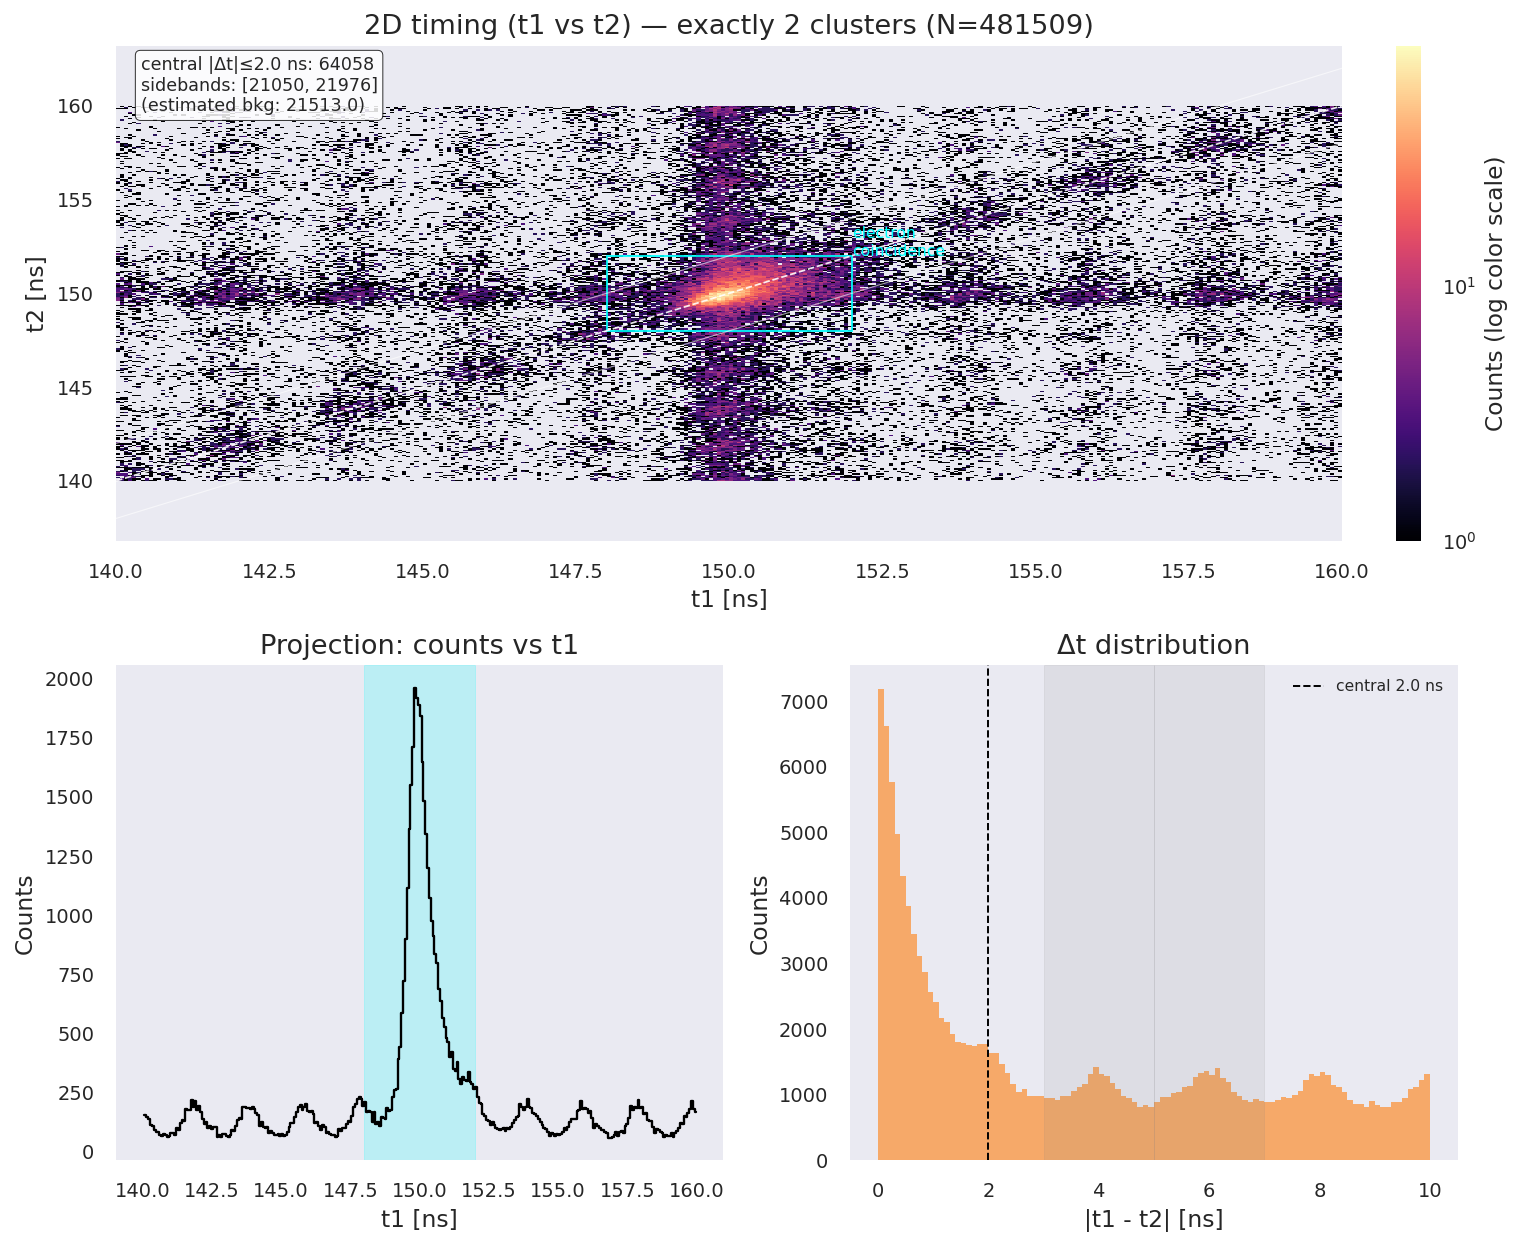


=== Guidance for data-driven background subtraction ===
1) Use the central |Δt| ≤ 2.0 ns bin-count as signal+accidentals.
2) Use the average of the sideband counts (scaled to central width) to estimate accidentals.
   Sidebands used: [(3.0, 5.0), (5.0, 7.0)]
3) Optionally perform 2D sideband subtraction: take equivalent-area regions parallel to the diagonal
   and subtract their normalized counts from the central diagonal band to obtain a 2D background-subtracted map.
4) Use the 'both_in' / 'one_in' / 'none_in' breakdown to test how many photon pairs coincide with the electron time (~150 ns).
5) If you want, I can add automated 2D sideband-subtraction code (produce background-subtracted heatmap).


In [28]:
# === 2D timing analysis for events with exactly 2 clusters (Jupyter cell) ===
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from collections import Counter

# ---------------------------
# Parameters (edit if desired)
# ---------------------------
HIST_MIN, HIST_MAX = 140.0, 160.0   # time axis limits (ns)
N_BINS = 300                        # resolution of 2D heatmap
DT_COIN_NS = 2.0                    # photon-photon central coincidence (|t1-t2| <= DT_COIN_NS)
ELE_CENTER = 150.0                  # electron-coincidence center time
ELE_WIN = 2.0                       # window around 150 ns to tag in-electron-coincidence
SIDEBAND_RANGES = [(3.0, 5.0), (5.0, 7.0)]  # dt sidebands (ns) for accidental estimate

SAVE_FIGS = False                    # set True to save figures to disk
FIG_PREFIX = "timing2d"              # saved figure prefix if SAVE_FIGS True

# ---------------------------
# Helper: safe branch fetch
# returns awkward Array or None
# ---------------------------
def get_branch_safe(name):
    # branches must be an awkward record object with .fields (from uproot tree.arrays(..., library="ak"))
    if not hasattr(branches, "fields"):
        raise RuntimeError("Variable 'branches' not found or not an awkward record. Create it with tree.arrays(library='ak').")
    if name in branches.fields:
        return branches[name]
    else:
        # silent fallback is helpful during interactive debugging
        print(f"[warn] branch '{name}' not found in skim; skipping it.")
        return None

# ---------------------------
# Fetch required branches
# ---------------------------
clusE = get_branch_safe("NPS.cal.clusE")
clusT = get_branch_safe("NPS.cal.clusT")
# optional electron-selection branches (we will NOT use electron time)
hdelta = get_branch_safe("H.gtr.dp")
HgtrTh = get_branch_safe("H.gtr.th")
HgtrPh = get_branch_safe("H.gtr.ph")
hcer   = get_branch_safe("H.cer.npeSum")

# Check for calorimeter total either name
hcaltot = None
branch_names = branches.fields
if "H.cal.etot" in branch_names:
    hcaltot = get_branch_safe("H.cal.etot")
elif "H.cal.etotnorm" in branch_names:
    hcaltot = get_branch_safe("H.cal.etotnorm")
# do not raise—we'll simply skip the cut if missing

# sanity
if clusE is None or clusT is None:
    raise RuntimeError("Required cluster branches not found: NPS.cal.clusE and/or NPS.cal.clusT")

# ---------------------------
# Build electron preselection mask (exclude electron time)
# Uses: hdelta between -15..15, HgtrTh/Ph in [-1,1], hcer>0.001, hcaltot>0.001 (if present)
# If a branch is missing, that cut is skipped.
# ---------------------------
n_events = len(clusE)
ele_mask = np.ones(n_events, dtype=bool)

# helper to try convert awkward to numpy safely (if scalar-like or ragged)
def ak_to_np_safe(arr):
    if arr is None:
        return None
    try:
        return ak.to_numpy(arr)
    except Exception:
        # try converting elementwise by list -> numpy
        try:
            return np.array(ak.to_list(arr))
        except Exception:
            return None

if hdelta is not None:
    hd = ak_to_np_safe(hdelta)
    if hd is not None and hd.shape[0] == n_events:
        ele_mask &= (hd > -15.0) & (hd < 15.0)
    else:
        print("[warn] couldn't convert H.gtr.dp to numpy or shape mismatch - skipping that cut")

if HgtrTh is not None:
    th = ak_to_np_safe(HgtrTh)
    if th is not None and th.shape[0] == n_events:
        ele_mask &= (th > -1.0) & (th < 1.0)
    else:
        print("[warn] couldn't convert H.gtr.th - skipping that cut")

if HgtrPh is not None:
    ph = ak_to_np_safe(HgtrPh)
    if ph is not None and ph.shape[0] == n_events:
        ele_mask &= (ph > -1.0) & (ph < 1.0)
    else:
        print("[warn] couldn't convert H.gtr.ph - skipping that cut")

if hcer is not None:
    cer = ak_to_np_safe(hcer)
    if cer is not None and cer.shape[0] == n_events:
        ele_mask &= (cer > 0.001)
    else:
        print("[warn] couldn't convert H.cer.npeSum - skipping that cut")

if hcaltot is not None:
    cal = ak_to_np_safe(hcaltot)
    if cal is not None and cal.shape[0] == n_events:
        ele_mask &= (cal > 0.001)
    else:
        print("[warn] couldn't convert H.cal.etot - skipping that cut")

# ---------------------------
# Multiplicity summary (all events, before selecting 2-cluster subset)
# ---------------------------
mult = ak.num(clusE)              # awkward array of per-event cluster counts
mult_counts = Counter(ak.to_numpy(mult))
total_events = len(mult)

print("=== Multiplicity summary (all events) ===")
for m in sorted(mult_counts.keys()):
    cnt = mult_counts[m]
    print(f"  nclus = {m:2d} : {cnt:7d} events  ({100.0*cnt/total_events:5.2f}%)")
print(f"Total events: {total_events}\n")

# ---------------------------
# Select events: exactly 2 clusters & pass electron preselection
# ---------------------------
mask_two = ak.to_numpy(ak.num(clusE) == 2)   # numpy boolean array
sel_mask = mask_two & ele_mask               # numpy boolean
sel_idx = np.where(sel_mask)[0]              # indices of selected events (numpy array)
n_sel = len(sel_idx)
print(f"[info] Events with exactly 2 clusters & passing electron cuts: {n_sel}  (from {total_events} total)")

if n_sel == 0:
    raise RuntimeError("No events selected. Check cuts or branch contents.")

# ---------------------------
# Extract t1, t2 arrays for selected events
# ---------------------------
t1 = np.zeros(n_sel, dtype=np.float64)
t2 = np.zeros(n_sel, dtype=np.float64)
e1 = np.zeros(n_sel, dtype=np.float64)
e2 = np.zeros(n_sel, dtype=np.float64)

for ii, ev in enumerate(sel_idx):
    # awkward indexing returns nested sequence; convert safely
    try:
        ev_t = ak.to_list(clusT[ev])   # expected length == 2
        ev_e = ak.to_list(clusE[ev])
    except Exception:
        # fallback, attempt direct numpy conversion per event
        ev_t = list(np.array(clusT[ev].tolist()))
        ev_e = list(np.array(clusE[ev].tolist()))

    if len(ev_t) < 2 or len(ev_e) < 2:
        t1[ii] = np.nan; t2[ii] = np.nan; e1[ii] = 0.0; e2[ii] = 0.0
        continue
    # keep ordering as stored (if you need sorted by energy, do that separately)
    t1[ii] = float(ev_t[0]); t2[ii] = float(ev_t[1])
    e1[ii] = float(ev_e[0]); e2[ii] = float(ev_e[1])

# remove any NaNs (shouldn't be common)
valid = np.isfinite(t1) & np.isfinite(t2)
t1 = t1[valid]; t2 = t2[valid]; e1 = e1[valid]; e2 = e2[valid]
n_valid = len(t1)
print(f"[info] Valid 2-cluster events after conversion: {n_valid}")

# ---------------------------
# Build 2D histogram (t1 vs t2)
# ---------------------------
bins = N_BINS
xbins = np.linspace(HIST_MIN, HIST_MAX, bins + 1)
ybins = xbins.copy()

H, xedges, yedges = np.histogram2d(t1, t2, bins=[xbins, ybins])

# ---------------------------
# Compute statistics for central band and sidebands (using dt = |t1-t2|)
# ---------------------------
dt = np.abs(t1 - t2)
central_mask = dt <= DT_COIN_NS
sideband_masks = [ (dt >= lo) & (dt < hi) for (lo,hi) in SIDEBAND_RANGES ]

central_count = int(central_mask.sum())
side_counts = [int(m.sum()) for m in sideband_masks]
n_total_pairs = int(n_valid)

# categories relative to electron time (150 ns)
both_in = int(np.sum( (np.abs(t1 - ELE_CENTER) <= ELE_WIN) & (np.abs(t2 - ELE_CENTER) <= ELE_WIN) ))
one_in  = int(np.sum( ((np.abs(t1 - ELE_CENTER) <= ELE_WIN) ^ (np.abs(t2 - ELE_CENTER) <= ELE_WIN)) ))  # xor
none_in = int(np.sum( (np.abs(t1 - ELE_CENTER) > ELE_WIN) & (np.abs(t2 - ELE_CENTER) > ELE_WIN) ))

print("\n=== Timing coincidence summary (2-cluster events) ===")
print(f"Total 2-cluster events considered: {n_total_pairs}")
print(f"Central photon-photon coincidences (|dt| <= {DT_COIN_NS} ns): {central_count}")
for (lo,hi),cnt in zip(SIDEBAND_RANGES, side_counts):
    print(f"Sideband |dt| in [{lo:.1f},{hi:.1f}) ns : {cnt}")
# sideband→background estimate (scale sideband average to central width)
widths = [hi-lo for (lo,hi) in SIDEBAND_RANGES]
scaled = [ (c * (DT_COIN_NS / w)) if w>0 else 0.0 for c,w in zip(side_counts, widths) ]
bkg_est = float(np.mean(scaled)) if len(scaled)>0 else 0.0
signal_est = central_count - bkg_est
print(f"Estimated accidental background from sidebands (avg scaled): {bkg_est:.1f}")
print(f"Estimated signal ≈ central - bkg ≈ {signal_est:.1f}\n")

print("Coincidence vs electron-time categories (central window around 150 ns = ±{:.1f} ns):".format(ELE_WIN))
print(f"  both_in : {both_in}  ({100.0*both_in/n_total_pairs:5.2f}%)")
print(f"  one_in  : {one_in}   ({100.0*one_in/n_total_pairs:5.2f}%)")
print(f"  none_in : {none_in}  ({100.0*none_in/n_total_pairs:5.2f}%)\n")

# ---------------------------
# Additional info: top-2 fraction for best-candidate DataFrames if present
# (the DF must have 'event','i','j' columns)
# ---------------------------
def top2_fraction_from_df(df):
    if df is None or len(df)==0:
        return None
    ok_cnt = 0
    total = 0
    for row in df.itertuples(index=False):
        ev = int(row.event)
        energies = ak.to_list(clusE[ev])
        if len(energies) < 2:
            continue
        idx_sorted = np.argsort(energies)[::-1]  # descending
        top2 = set([int(idx_sorted[0]), int(idx_sorted[1])])
        pair = set([int(row.i), int(row.j)])
        total += 1
        if pair == top2:
            ok_cnt += 1
    frac = ok_cnt / total if total>0 else 0.0
    return ok_cnt, total, frac

for name in ("df_best_oa","df_best_mass"):
    if name in globals():
        df = globals()[name]
        info = top2_fraction_from_df(df)
        if info is not None:
            ok_cnt, total, frac = info
            print(f"[info] {name}: {ok_cnt}/{total} best-candidate pairs come from top-2 energy clusters ({100.*frac:5.2f}%)")
        else:
            print(f"[info] {name}: no info (empty or missing)")

# ---------------------------
# Plotting: aesthetic 2D heatmap + projections + dt histogram
# ---------------------------
plt.rcParams.update({
    "figure.dpi": 140,
    "font.size": 10,
    "axes.grid": False,
    "image.cmap": "magma"
})

# color normalization: use LogNorm if there are non-zero bins
H_nonzero = H[H>0]
if H_nonzero.size > 0:
    vmin = max(1, int(H_nonzero.min()))
    vmax = int(H.max())
    norm = LogNorm(vmin=vmin, vmax=vmax)
else:
    norm = None

fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(2,2,(1,2))  # top: big heatmap across two columns

# plot heatmap using pcolormesh (matching edges)
X, Y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(X, Y, H.T, cmap="magma", norm=norm, shading='auto')
cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Counts (log color scale)" if norm else "Counts")

ax.set_xlabel("t1 [ns]")
ax.set_ylabel("t2 [ns]")
ax.set_title(f"2D timing (t1 vs t2) — exactly 2 clusters (N={n_valid})")

# diagonal and central band overlays
ax.plot([HIST_MIN, HIST_MAX], [HIST_MIN, HIST_MAX], color='white', linestyle='--', lw=0.9, alpha=0.9)
ax.plot([HIST_MIN, HIST_MAX], [HIST_MIN + DT_COIN_NS, HIST_MAX + DT_COIN_NS], color='w', lw=0.6, alpha=0.6)
ax.plot([HIST_MIN, HIST_MAX], [HIST_MIN - DT_COIN_NS, HIST_MAX - DT_COIN_NS], color='w', lw=0.6, alpha=0.6)

# electron-coincidence box (both clusters near 150±ELE_WIN)
rect = Rectangle((ELE_CENTER - ELE_WIN, ELE_CENTER - ELE_WIN),
                 2*ELE_WIN, 2*ELE_WIN,
                 linewidth=1.0, edgecolor='cyan', facecolor='none', linestyle='-', alpha=0.9)
ax.add_patch(rect)
ax.text(ELE_CENTER + 2.0, ELE_CENTER + 2.0, "electron\ncoincidence", color='cyan', fontsize=8)

# annotation box with counts
ax.text(0.02, 0.98,
        f"central |Δt|≤{DT_COIN_NS} ns: {central_count}\nsidebands: {side_counts}\n(estimated bkg: {bkg_est:.1f})",
        transform=ax.transAxes, va='top', ha='left', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85))

# projections and |dt| histogram bottom-left and bottom-right
ax1 = fig.add_subplot(2,2,3)  # left-bottom: projection t1 (counts vs t)
ax2 = fig.add_subplot(2,2,4)  # right-bottom: dt histogram

# projection along t2 integrated (counts vs t1)
proj_t1 = H.sum(axis=1)   # sum over columns (y)
centers = 0.5*(xedges[:-1] + xedges[1:])
ax1.plot(centers, proj_t1, drawstyle='steps-mid', color='black', linewidth=1.2)
ax1.set_xlabel("t1 [ns]")
ax1.set_ylabel("Counts")
ax1.set_title("Projection: counts vs t1")
ax1.axvspan(ELE_CENTER - ELE_WIN, ELE_CENTER + ELE_WIN, color='cyan', alpha=0.2)

# dt histogram
bins_dt = np.linspace(0.0, 10.0, 101)
ax2.hist(dt, bins=bins_dt, histtype='stepfilled', alpha=0.6, color='C1')
ax2.axvline(DT_COIN_NS, color='k', linestyle='--', lw=1.0, label=f'central {DT_COIN_NS} ns')
for (lo,hi) in SIDEBAND_RANGES:
    ax2.axvspan(lo, hi, alpha=0.12, color='gray')
ax2.set_xlabel("|t1 - t2| [ns]")
ax2.set_ylabel("Counts")
ax2.set_title("Δt distribution")
ax2.legend(fontsize=8)

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(f"{FIG_PREFIX}_2dtiming_summary.png", dpi=200)

plt.show()

# ---------------------------
# Print short guidance for background subtraction and next steps
# ---------------------------
print("\n=== Guidance for data-driven background subtraction ===")
print("1) Use the central |Δt| ≤ {:.1f} ns bin-count as signal+accidentals.".format(DT_COIN_NS))
print("2) Use the average of the sideband counts (scaled to central width) to estimate accidentals.")
print("   Sidebands used:", SIDEBAND_RANGES)
print("3) Optionally perform 2D sideband subtraction: take equivalent-area regions parallel to the diagonal")
print("   and subtract their normalized counts from the central diagonal band to obtain a 2D background-subtracted map.")
print("4) Use the 'both_in' / 'one_in' / 'none_in' breakdown to test how many photon pairs coincide with the electron time (~150 ns).")
print("5) If you want, I can add automated 2D sideband-subtraction code (produce background-subtracted heatmap).")
